# <center> **Лекция 9:** Компьютерное зрение. GANs. Архитектура и принцип работы. </center>
----
<br>
</br>


<center> <img src=./../src/imgs/gans_intro_img.png> </center>

<br>
</br>

----

## __План на сегодня:__

----

### 1. __Что такое Генеративно-Состязательная Сеть. Базовая архитектура. Принцип работы.__
### 2. __Архитектуры Генеративно-Состязатльных Сетей.__
### 3. __Применение.__

# Часть 1: Генеративно-Состязательная Сеть (GAN). Базовая архитектура. Принцип работы.

----


<br>
</br>

Для того, чтобы понять что такое Генеративно-Состязательная Сеть и принцип ее работы, нам лучше сначала разобраться с компонентами генеративно-созятальной сети, а именно:
1. **Генератор (G).**
2. **Дискриминатор (D).**

<br>
</br>

<img src=./../src/imgs/vanilla_gan.png>

<br>
</br>

**Генеративная часть сети (генератор)** обучается представлению на основе выборки изображений и затем пытается сгенерировать похожие изображения, которые максимально должны повторять характеристики изображений из основной выборки. **Дискриминантная часть сети (или просто дискриминатор)** берет "рассматривает" изображение, которые было сгенерированно генератором и исходную выборку изображений и занимается классификацией сгенерированного изображения как исходное (то есть подлинное) или фейк (то есть с большей вероятностью сгенерированное генератором).

<br>
</br>

Сеть-генератор (G) занимается генерирацией изображения таким образом, чтобы дискриминатор (D) классифицировал их как настоящие. Сеть-дискриминатор классифицирует сгенерированные изображения как поддельные, а изображения в исходном образце - как настоящие. По сути, термин adversarial в GAN (Generative Adversarial Network) представляет собой противоположную природу двух сетей - сети-генератора, которая генерирует изображения, чтобы обмануть сеть-дискриминатор, и сети-дискриминатора, которая классифицирует каждое изображение, говоря, является ли оно сгенерированным или оригинальным.

<br>
</br>

Окей с базовыми понятиями мы разобрались, теперь остается понять как мы считаем функцию потерь для обеих частей (дискриминатора и генератора) для того, чтобы тренировать компоненты сети одновременно. Для объяснения очень кстати подойдет моя схемка:

<br>
</br>

<img src=./../src/imgs/training_gan.png>

<br>
</br>

Исходя из логики схемы, процесс тренировки Генеративно-Состязательных сетей состоит из следующих шагов:
1. Обучить генератор (но не дискриминатор) генерировать такие изображения, чтобы дискриминатор классифицировал их как настоящие.
2. Обучить дискриминатор (а не генератор) классифицировать изображения, которые генерирует генератор, как поддельные.
3. Повторить весь этот процесс до тех пор, пока не будет достигнуто равновесие (о нем чуть позже).

Когда дискриминатор действительно хорошо распознает сгенерированные изображения, потери, соответствующие генератору, значительно выше по сравнению с потерями, соответствующими дискриминатору. Таким образом, градиенты настраиваются таким образом, чтобы генератор имел потери. Однако при этом потери дискриминатора будут смещены в большую сторону. На следующей итерации градиенты подстраиваются таким образом, чтобы потери дискриминатора были меньше. Таким образом, генератор и дискриминатор продолжают обучаться до тех пор, пока генератор не начнет генерировать реалистичные изображения, а дискриминатор не сможет отличить реальное изображение от сгенерированного.


<br>
</br>

Давайте посмотрим на логику работы и код в задаче генерации пока простеньких рукописных чисел из того же классического датасета MNIST:

In [2]:
from torch_snippets import *
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5,), std=(0.5,))
        ])

In [4]:
data_loader = torch.utils.data.DataLoader(MNIST('./mnist', train=True, download=True, transform=transform), batch_size=128, shuffle=True, drop_last=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 56828473.54it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21996675.84it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 12509186.50it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12418858.39it/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



Определим класс дискриминатора:

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential( 
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x): 
        return self.model(x)

In [6]:
from torchsummary import summary

discriminator = Discriminator().to(device)
summary(discriminator, (1,784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1024]         803,840
         LeakyReLU-2              [-1, 1, 1024]               0
           Dropout-3              [-1, 1, 1024]               0
            Linear-4               [-1, 1, 512]         524,800
         LeakyReLU-5               [-1, 1, 512]               0
           Dropout-6               [-1, 1, 512]               0
            Linear-7               [-1, 1, 256]         131,328
         LeakyReLU-8               [-1, 1, 256]               0
           Dropout-9               [-1, 1, 256]               0
           Linear-10                 [-1, 1, 1]             257
          Sigmoid-11                 [-1, 1, 1]               0
Total params: 1,460,225
Trainable params: 1,460,225
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

Определим класс генератора:

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x): 
        return self.model(x)

In [8]:
generator = Generator().to(device)
summary(generator, (1,100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]          25,856
         LeakyReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 512]         131,584
         LeakyReLU-4               [-1, 1, 512]               0
            Linear-5              [-1, 1, 1024]         525,312
         LeakyReLU-6              [-1, 1, 1024]               0
            Linear-7               [-1, 1, 784]         803,600
              Tanh-8               [-1, 1, 784]               0
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 5.67
Estimated Total Size (MB): 5.71
----------------------------------------------------------------


Функция, которая отвечает за генерацию случайного шума для генератора:

In [9]:
def noise(size):
    n = torch.randn(size, 100)
    return n.to(device)

Окей на самом деле большая часть работы готова, теперь нам необходимо будет определить функцию, которая отвечает за процесс тренировки дискриминатора. Как мы помним цель дискриминатора - не дать себя обмануть. Таким образом, логика дисриминатора следующая - он принимает реальные данные (изображение) и данные сгенерированные генератором (потенциальный фейк) в качестве инпута. Нам необходимо сделать предсказание из дискриминатора и посчитать лосс для наших данных и провести процесс обратного распространения ошибки, то есть все то, что мы и делаем обычно:

In [10]:
def discriminator_train_step(real_data, fake_data):
    d_optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, torch.ones(len(real_data), 1).to(device))
    error_real.backward()
    prediction_fake = discriminator(fake_data)
    # When we calculate the discriminator loss on real data, we expect the discriminator to predict an output of 1. 
    # Hence, the discriminator loss on real data is calculated by expecting the discriminator to predict output as 1 using torch.ones during discriminator training.
    error_fake = loss(prediction_fake, torch.zeros(len(fake_data), 1).to(device))
    error_fake.backward()
    # Update the weights and return the overall loss (summing up the loss values of error_real on real_data and error_fake on fake_data):
    d_optimizer.step()
    return error_real + error_fake

Аналогично определим функцию которая будет отвечать за тренировку генератора:

In [11]:
def generator_train_step(fake_data):
    # Reset the gradients of the generator optimizer
    g_optimizer.zero_grad()
    # Predict the output of the discriminator on fake data (fake_data)
    prediction = discriminator(fake_data)
    # Calculate the generator loss value by passing prediction and the expected value as torch.ones since 
    # we want to fool the discriminator to output a value of 1 when training the generator
    error = loss(prediction, torch.ones(len(real_data), 1).to(device))
    # Perform backpropagation, update the weights, and return the error
    error.backward()
    g_optimizer.step()
    return error

In [12]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

loss = nn.BCELoss()

num_epochs = 200
log = Report(num_epochs)

In [13]:
# Loop through 200 epochs (num_epochs) over the data_loader function 
for epoch in range(num_epochs):
    N = len(data_loader)
    for i, (images, _) in enumerate(data_loader):
        # Load real data (real_data) and fake data, where fake data is obtained 
        # by passing noise (with a batch size of the number of data points in real_data – len(real_data)) through the generator network
        real_data = images.view(len(images), -1).to(device)
        fake_data = generator(noise(len(real_data))).to(device)
        fake_data = fake_data.detach()
        
        d_loss = discriminator_train_step(real_data, fake_data)
        
        fake_data = generator(noise(len(real_data))).to(device)
        
        g_loss = generator_train_step(fake_data)
        
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')
    log.report_avgs(epoch+1)

EPOCH: 1.000  g_loss: 3.485  d_loss: 0.809  (97.71s - 19444.72s remaining)))
EPOCH: 2.000  g_loss: 2.496  d_loss: 0.932  (120.92s - 11970.59s remaining)
EPOCH: 3.000  g_loss: 1.792  d_loss: 0.943  (144.95s - 9518.29s remaining))
EPOCH: 4.000  g_loss: 2.395  d_loss: 0.901  (168.73s - 8267.83s remaining)
EPOCH: 5.000  g_loss: 2.018  d_loss: 0.828  (190.29s - 7421.25s remaining)
EPOCH: 6.000  g_loss: 2.891  d_loss: 0.527  (211.74s - 6846.16s remaining)
EPOCH: 7.000  g_loss: 2.934  d_loss: 0.583  (233.15s - 6428.30s remaining)
EPOCH: 8.000  g_loss: 2.748  d_loss: 0.535  (254.70s - 6112.85s remaining)
EPOCH: 9.000  g_loss: 2.652  d_loss: 0.538  (276.23s - 5862.32s remaining)
EPOCH: 10.000  g_loss: 2.724  d_loss: 0.553  (297.69s - 5656.05s remaining)
EPOCH: 11.000  g_loss: 2.610  d_loss: 0.575  (319.19s - 5484.35s remaining)
EPOCH: 12.000  g_loss: 2.593  d_loss: 0.583  (340.82s - 5339.55s remaining)
EPOCH: 13.000  g_loss: 2.541  d_loss: 0.588  (362.27s - 5211.05s remaining)
EPOCH: 14.000  g_

KeyboardInterrupt: 

100%|██████████| 301/301 [00:01<00:00, 153.62it/s]


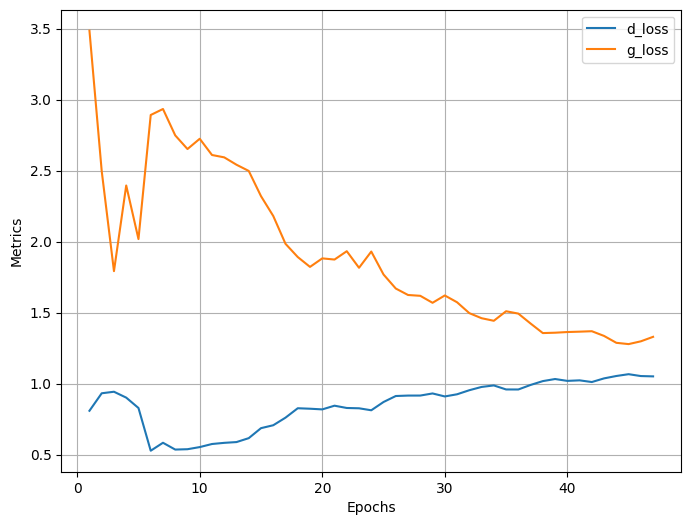

In [14]:
log.plot_epochs(['d_loss', 'g_loss'])

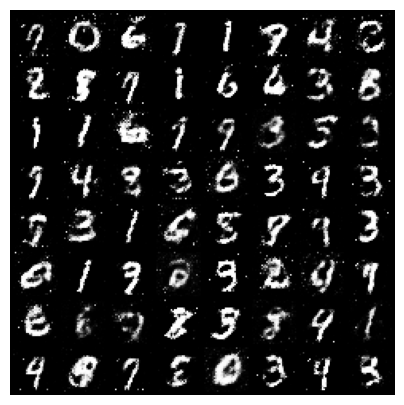

In [15]:
z = torch.randn(64, 100).to(device)

sample_images = generator(z).data.cpu().view(64, 1, 28, 28)

grid = make_grid(sample_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=5)
     

# Часть 2: Архитектуры Генеративно-Состязательных Сетей.

----


<br>
</br>


## DCGAN - Deep Convolutional Neural Network: 

<br>
</br>

Опять таки мы переходим к сверточной нейронной сети. Почему? 

Потому что как мы знаем сверточные сетки очень хорошо справляются с пространственной структурой изображения и более эффективны в компьютерном зрении чем ванильная генеративно-состязательная сеть, где мы можем столкнуться с огромным количеством проблем. 

<br>
</br>

Подход, который мы будем использовать для генерации изображения с помощью набора из 100 случайных чисел:
- Сначала преобразуем случайный шум в форму батча  размерности x 100 x 1 x 1. Почему такой формат, потому что мы начинаем использовать свертку, которая требуут входных данных в виде размерности - [батч x каналы x высота x ширина]
- Затем нам необходимо будет обратно трансформировать сгенерированный шум (потенциальную картинку) обратно в размерность соответствующей картинке при помощи опреации деконволюции, то есть, используя класс ConvTranspose2d.
- Остальное остается так же как и в обычной "ванильной" Генеративно-Состязательной сети.

<br>
</br>

Имея эти знания давайте посмотроим и обучим Генеративно-Состязательную Сеть для генерации лиц людей:

In [16]:
from torch_snippets import *
import torchvision
from torchvision import transforms
import torchvision.utils as vutils
import cv2
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
device = "cuda" if torch.cuda.is_available() else "cpu"

Определим Dataset и DataLoader для наших картинок лиц. Необходимо убедиться, что мы обрезаем изображения таким образом, чтобы сохранить только лица и отбросить дополнительные детали на изображении. Загрузим хаар каскад фильтр, который поможет определить лица на изображении и реализовать обрезку изображения по распознанному баундинг боксу лица:

In [17]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

Создадим новую папку для нашего датасета и будем складывать туда все что мы обработали для целей нашей работы:

In [18]:
!mkdir cropped_faces
images = Glob('./../data/male_female_face_images/females/*.jpg') + Glob('./../data/male_female_face_images/males/*.jpg')

for i in range(len(images)):
    img = read(images[i],1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    for (x,y,w,h) in faces:
        img2 = img[y:(y+h),x:(x+w),:]
    cv2.imwrite('cropped_faces/'+str(i)+'.jpg', cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))

In [19]:
transform=transforms.Compose([transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Определим датасет

In [20]:
class Faces(Dataset):
    def __init__(self, folder):
        super().__init__()
        self.folder = folder
        self.images = sorted(Glob(folder))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, ix):
        image_path = self.images[ix]
        image = Image.open(image_path)
        image = transform(image)
        return image

In [21]:
ds = Faces(folder='cropped_faces/')

In [22]:
dataloader = DataLoader(ds, batch_size=64, shuffle=True, num_workers=8)

Определим простую инициализацию весов таким образом, чтобы веса имели меньший разброс для целей упрощения обучения генеративно-состязательной сети:

In [23]:
def weights_init(m):
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Определим класс Discriminator, который принимает изображение размерностью [batch_size x 3 x 64 x 64] и предсказывает, является ли изображние реальным или поддельным:

In [24]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
                        nn.Conv2d(3, 64, 4, 2, 1, bias=False),
                        nn.LeakyReLU(0.2, inplace=True),
                        nn.Conv2d(64, 64*2, 4, 2, 1,bias=False),
                        nn.BatchNorm2d(64*2),
                        nn.LeakyReLU(0.2,inplace=True),
                        nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(64*4),
                        nn.LeakyReLU(0.2, inplace=True),
                        nn.Conv2d(64*4, 64*8, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(64*8),
                        nn.LeakyReLU(0.2,inplace=True),
                        nn.Conv2d(64*8, 1, 4, 1, 0,bias=False),
                        nn.Sigmoid()
                    )
        self.apply(weights_init)    
    
    def forward(self, input): 
        return self.model(input)

In [25]:
from torchsummary import summary

discriminator = Discriminator().to(device)
summary(discriminator, (3,64,64));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

Определим класс Generator, который генерирует фальшивые изображения из входного массива размерностью [batch_size x 100 x 1 x 1]:

In [26]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 64*8, 4, 1, 0, bias=False,),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*8,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*4,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*2,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,3,4,2,1,bias=False),
            nn.Tanh()
        )
        self.apply(weights_init)
    
    def forward(self,input): 
        return self.model(input)

In [27]:
generator = Generator().to(device)

summary(generator, (100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [28]:
def discriminator_train_step(real_data, fake_data):
    d_optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    
    error_real = loss(prediction_real.squeeze(), torch.ones(len(real_data)).to(device))
    error_real.backward()
    
    prediction_fake = discriminator(fake_data)
    
    error_fake = loss(prediction_fake.squeeze(), torch.zeros(len(fake_data)).to(device))
    error_fake.backward()
    
    d_optimizer.step()
    return error_real + error_fake

def generator_train_step(fake_data):
    g_optimizer.zero_grad()
    
    prediction = discriminator(fake_data)
    
    error = loss(prediction.squeeze(), torch.ones(len(real_data)).to(device))
    error.backward()
    
    g_optimizer.step()
    return error

In [29]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

loss = nn.BCELoss()

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [30]:
log = Report(25)

for epoch in range(25):
    N = len(dataloader)
    
    for i, images in enumerate(dataloader):
        
        real_data = images.to(device)
        
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        fake_data = fake_data.detach()
        
        d_loss = discriminator_train_step(real_data, fake_data)
        
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        g_loss = generator_train_step(fake_data)
        
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')
    log.report_avgs(epoch+1)

EPOCH: 1.000  g_loss: 9.257  d_loss: 0.645  (329.60s - 7910.28s remaining))
EPOCH: 2.000  g_loss: 5.777  d_loss: 0.567  (663.97s - 7635.62s remaining))
EPOCH: 3.000  g_loss: 4.672  d_loss: 0.502  (1006.17s - 7378.60s remaining)
EPOCH: 4.000  g_loss: 4.125  d_loss: 0.544  (1370.53s - 7195.28s remaining))
EPOCH: 4.078  d_loss: 1.722  g_loss: 9.230  (1397.96s - 7171.93s remaining)

KeyboardInterrupt: 

100%|██████████| 126/126 [00:00<00:00, 1463.43it/s]


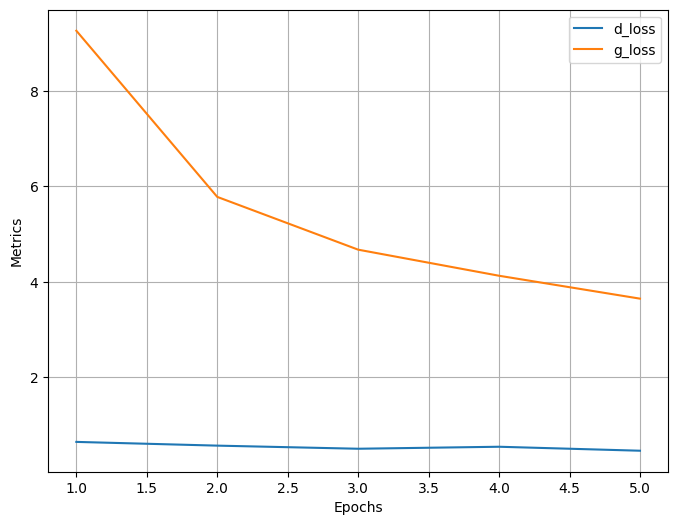

In [31]:
log.plot_epochs(['d_loss','g_loss'])

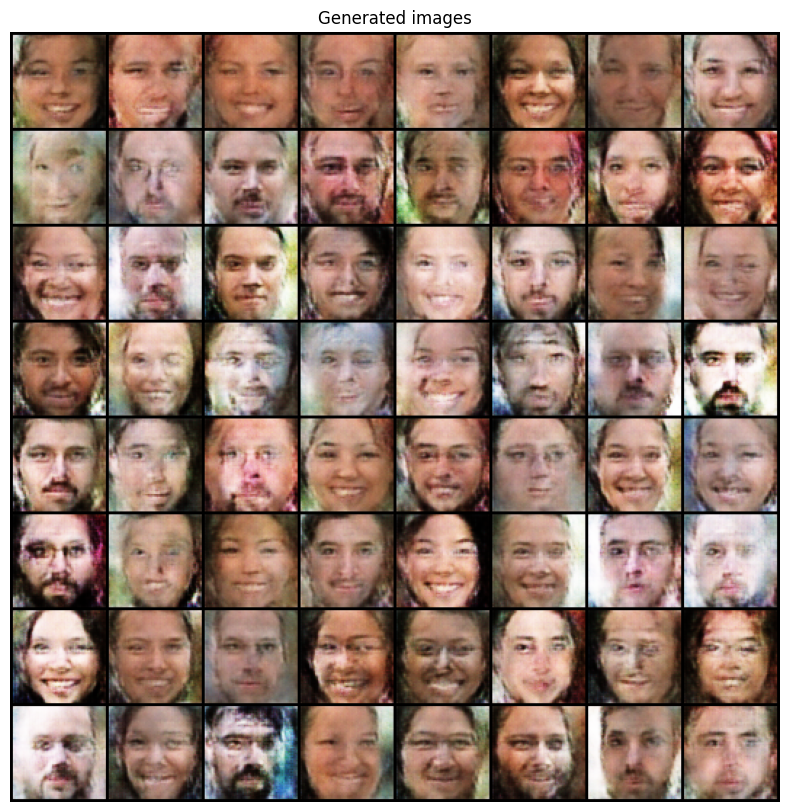

In [32]:
generator.eval()
noise = torch.randn(64, 100, 1, 1, device=device)
sample_images = generator(noise).detach().cpu()
grid = vutils.make_grid(sample_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=10, title='Generated images')

<br>
</br>


## cGAN - Conditional Generative Adversarial Network - Условная  Генеративно-Состязательная Сеть: 

<br>
</br>

Уже должно быть понятно из названия для чего нам нужен такой тип генеративно-состязательной сети. Предсавим кейс, в котором мы хотим сгенерировать изображение интересующего нас класса, например, изображение кошки, собаки или человека в очках. Как указать, что мы хотим сгенерировать интересующее нас изображение? В этом случае на помощь приходят условные GAN.

<br>
</br>

Пока предположим, что у нас есть только изображения мужских и женских лиц вместе с соответствующими метками. Тот самый датасет, который и был до этого. Стратегия будет заключаться в следующем подходе: 
1. Задаем метку изображения, которое хотим сгенерировать, в виде one-hot-encoded вектора.
2. Пропускаем метку через слой эмбеддинга для создания многомерного представления каждого класса (либо одного класса).
3. Генерируем случайный шум и конкатенируем его со слоем эмбеддинга, созданным на предыдущем шаге.
4. Обучить модель, как и в предыдущих подходах, но на этот раз с вектором шума, скомбинированным с эмбеддингом класса изображения, которые мы хотим сгенерировать.

Приступим:

In [33]:
from torch_snippets import *
from torchvision.utils import make_grid
from torch_snippets import *
from PIL import Image
import torchvision
from torchvision import transforms
import torchvision.utils as vutils

device = "cuda" if torch.cuda.is_available() else "cpu"

In [34]:
female_images = Glob('./../data/male_female_face_images/females/*.jpg')
male_images = Glob('./../data/male_female_face_images/males/*.jpg')

In [35]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [36]:
!mkdir cropped_faces_female
!mkdir cropped_faces_male

for i in range(len(female_images)):
    img = read(female_images[i],1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        img2 = img[y:(y+h),x:(x+w),:]
    cv2.imwrite('./cropped_faces_female/'+str(i)+'.jpg',cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))
    
for i in range(len(male_images)):
    img = read(male_images[i],1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        img2 = img[y:(y+h),x:(x+w),:]
    cv2.imwrite('./cropped_faces_male/'+str(i)+'.jpg',cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))

In [37]:
transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

In [38]:
class Faces(Dataset):
    def __init__(self, folders):
        super().__init__()
        self.folderfemale = folders[0]
        self.foldermale = folders[1]
        self.images=sorted(Glob(self.folderfemale))+sorted(Glob(self.foldermale))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, ix):
        image_path = self.images[ix]
        image = Image.open(image_path)
        image = transform(image)
        gender = np.where('female' in str(image_path),1,0)
        return image, torch.tensor(gender).long()

In [39]:
ds = Faces(folders=['cropped_faces_female','cropped_faces_male'])
dataloader = DataLoader(ds, batch_size=64, shuffle=True, num_workers=8)

In [40]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Распишем класс Discriminator:

In [41]:
class Discriminator(nn.Module):
    def __init__(self, emb_size=32):
        super(Discriminator, self).__init__()
        # emb_size represents the number of embeddings into which we convert the input class label (the class of image we want to generate), 
        # which is stored as label_embeddings.
        self.emb_size = 32
        
        self.label_embeddings = nn.Embedding(2, self.emb_size)
        
        self.model = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*2,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*4,64*8,4,2,1,bias=False),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*8,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Flatten()
        )
        # model2 does the classification
        self.model2 = nn.Sequential(
            nn.Linear(288,100),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(100,1),
            nn.Sigmoid()
        )
        
        self.apply(weights_init)
        
    def forward(self, input, labels):
        # we are fetching the output of the first model (self.model(input)) 
        # and the output of passing labels through label_embeddings and then concatenating the outputs.
        x = self.model(input)
        y = self.label_embeddings(labels)
        input = torch.cat([x, y], 1)
        final_output = self.model2(input)
        return final_output

In [42]:
class Generator(nn.Module):
    def __init__(self, emb_size=32):
        super(Generator,self).__init__()
        
        self.emb_size = emb_size
        # we are using nn.Embedding to convert the 2D input (which is of classes) to a 32-dimensional vector (self.emb_size):
        self.label_embeddings = nn.Embedding(2, self.emb_size)
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100+self.emb_size,64*8,4,1,0,bias=False),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*8,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*4,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*2,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,3,4,2,1,bias=False),
            nn.Tanh()
        )
        self.apply(weights_init)
        
    def forward(self,input_noise,labels):
        #  method that takes the noise values (input_noise) and input label (labels) as input and generates the output of the image
        label_embeddings = self.label_embeddings(labels).view(len(labels), self.emb_size, 1, 1)
        input = torch.cat([input_noise, label_embeddings], 1)
        return self.model(input)

In [43]:
def noise(size):
    n = torch.randn(size, 100, 1, 1, device=device)
    return n.to(device)

In [44]:
def discriminator_train_step(real_data, real_labels, fake_data, fake_labels):
    d_optimizer.zero_grad()
    
    prediction_real = discriminator(real_data, real_labels)
    
    error_real = loss(prediction_real, torch.ones(len(real_data), 1).to(device))
    error_real.backward()
    
    prediction_fake = discriminator(fake_data, fake_labels)
    
    error_fake = loss(prediction_fake, torch.zeros(len(fake_data), 1).to(device))
    error_fake.backward()
    
    d_optimizer.step()    
    return error_real + error_fake

In [45]:
def generator_train_step(fake_data, fake_labels):
    g_optimizer.zero_grad()
    
    prediction = discriminator(fake_data, fake_labels)
    error = loss(prediction, torch.ones(len(fake_data), 1).to(device))
    error.backward()
    g_optimizer.step()
    return error

In [46]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

loss = nn.BCELoss()

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, 100, 1, 1, device=device)

fixed_fake_labels = torch.LongTensor([0]*(len(fixed_noise)//2) + [1]*(len(fixed_noise)//2)).to(device)

loss = nn.BCELoss()

n_epochs = 25
img_list = []

EPOCH: 1.000  g_loss: 3.386  d_loss: 0.398  (365.09s - 8762.13s remaining))


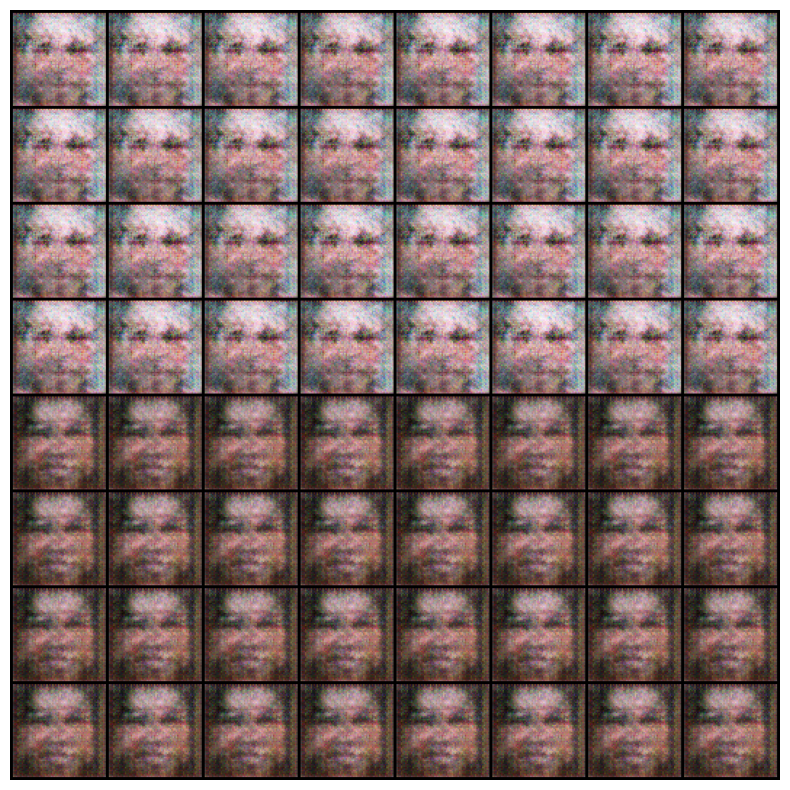

EPOCH: 1.375  d_loss: 0.535  g_loss: 2.919  (502.03s - 8625.79s remaining)

KeyboardInterrupt: 

In [47]:
log = Report(n_epochs)
for epoch in range(n_epochs):
    N = len(dataloader)
    for bx, (images, labels) in enumerate(dataloader):
        real_data, real_labels = images.to(device), labels.to(device)
        fake_labels = torch.LongTensor(np.random.randint(0, 2, len(real_data))).to(device)
        fake_data = generator(noise(len(real_data)), fake_labels)
        fake_data = fake_data.detach()
        d_loss = discriminator_train_step(real_data, real_labels, fake_data, fake_labels)
        fake_labels = torch.LongTensor(np.random.randint(0, 2, len(real_data))).to(device)
        fake_data = generator(noise(len(real_data)), fake_labels).to(device)
        g_loss = generator_train_step(fake_data, fake_labels)
        pos = epoch + (1+bx)/N
        log.record(pos, d_loss=d_loss.detach(), g_loss=g_loss.detach(), end='\r')
    log.report_avgs(epoch+1)
    with torch.no_grad():
        fake = generator(fixed_noise, fixed_fake_labels).detach().cpu()
        imgs = vutils.make_grid(fake, padding=2, normalize=True).permute(1,2,0)
        img_list.append(imgs)
        show(imgs, sz=10)

Если вам интересна тема Генеративных Сетей и вы хотите дальше углубиться в нее, то рекомендую следующие источники и курсы:

<br>
</br>

1. [StyleGAN Explanation and Code](https://paperswithcode.com/method/stylegan)
2. [Pix2Pix Explanation and Code](https://neptune.ai/blog/pix2pix-key-model-architecture-decisions)
3. [CycleGAN Explantion and Code](https://machinelearningmastery.com/what-is-cyclegan/)
4. [Diffusion Models Course HuggingFace](https://github.com/huggingface/diffusion-models-class)
5. [Stanfords GANs Course 2021](https://cs236g.stanford.edu/)